# Soccer Pass Prediction - Data Exploration

This notebook demonstrates the pass prediction model pipeline, including:
1. Data collection from StatsBomb
2. Feature engineering
3. Model training and evaluation
4. Analysis of results

In [1]:
# Setup
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import our modules
from config.config import config
from src.data.collectors.statsbomb import StatsBombCollector
from src.data.processors.processor import PassDataProcessor
from src.features.feature_engineering import FeatureEngineer
from src.models.baseline import PoissonRegression, HistoricalAverageBaseline
from src.evaluation.metrics import PassPredictionEvaluator

## 1. Data Collection

Let's start by collecting some data from StatsBomb's free dataset.

In [2]:
# Initialize collector
collector = StatsBombCollector()

# View available competitions
competitions = collector.get_competitions()
print("Available competitions:")
print(competitions[['competition_id', 'competition_name', 'season_name']].head(10))

Available competitions:
   competition_id        competition_name season_name
0               9           1. Bundesliga   2023/2024
1               9           1. Bundesliga   2015/2016
2            1267  African Cup of Nations        2023
3              16        Champions League   2018/2019
4              16        Champions League   2017/2018
5              16        Champions League   2016/2017
6              16        Champions League   2015/2016
7              16        Champions League   2014/2015
8              16        Champions League   2013/2014
9              16        Champions League   2012/2013


In [3]:
# Collect data for a specific competition (FIFA World Cup 2018)
competition_id = 43
season_id = 3

print(f"Collecting data for competition {competition_id}, season {season_id}...")
matches, events, lineups = collector.collect_competition_data(competition_id, season_id)

print(f"\nCollected:")
print(f"- {len(matches)} matches")
print(f"- {len(events)} events")
print(f"- {len(lineups)} lineup records")


Collected:
- 64 matches
- 227849 events
- 64 lineup records


In [4]:
# Aggregate player pass data
player_data = collector.aggregate_player_passes(events, matches, lineups)
print(f"\nPlayer-match records: {len(player_data)}")
print("\nSample data:")
player_data.head()


Player-match records: 2108

Sample data:


,match_id,team,player,position,passes_attempted,passes_completed,avg_pass_length,first_pass_minute,last_pass_minute,minutes_played,home_team,away_team,home_score,away_score,match_date,competition_stage,is_home,team_goals,opponent_goals,goal_difference
0,7525,Russia,Alan Dzagoev,Center Attacking Midfield,10,8,15.594281,6,16,10,Russia,Saudi Arabia,5,0,2018-06-14,Group Stage,True,5,0,5
1,7525,Russia,Aleksandr Golovin,Center Attacking Midfield,26,18,20.956830,24,92,68,Russia,Saudi Arabia,5,0,2018-06-14,Group Stage,True,5,0,5
2,7525,Russia,Aleksandr Golovin,Left Midfield,10,6,20.972996,4,21,17,Russia,Saudi Arabia,5,0,2018-06-14,Group Stage,True,5,0,5
3,7525,Russia,Aleksandr Samedov,Right Midfield,19,16,19.296674,0,62,62,Russia,Saudi Arabia,5,0,2018-06-14,Group Stage,True,5,0,5
4,7525,Russia,Artem Dzyuba,Center Forward,7,7,18.805044,74,90,16,Russia,Saudi Arabia,5,0,2018-06-14,Group Stage,True,5,0,5


## 2. Data Processing & Feature Engineering

In [5]:
# Process the data
processor = PassDataProcessor(min_minutes=15, exclude_goalkeepers=True)
processed_data, feature_matrix, feature_names = processor.process_data(player_data)

print(f"After processing: {len(processed_data)} records")
print(f"\nFeatures created: {feature_names}")

After processing: 1587 records

Features created: ['position_encoded', 'is_home', 'minutes_played', 'team_strength_diff', 'team_points_per_game', 'opponent_points_per_game', 'team_avg_goals', 'opponent_avg_goals', 'passes_attempted_rolling_5', 'passes_completed_rolling_5', 'minutes_played_rolling_5', 'avg_pass_length']


In [6]:
# Additional feature engineering
engineer = FeatureEngineer()
processed_data = engineer.engineer_features(processed_data, feature_set="intermediate")

# Update feature matrix
feature_matrix, feature_names = processor.create_model_features(processed_data)
print(f"\nEnhanced features: {len(feature_names)} total")


Enhanced features: 12 total


## 3. Exploratory Data Analysis

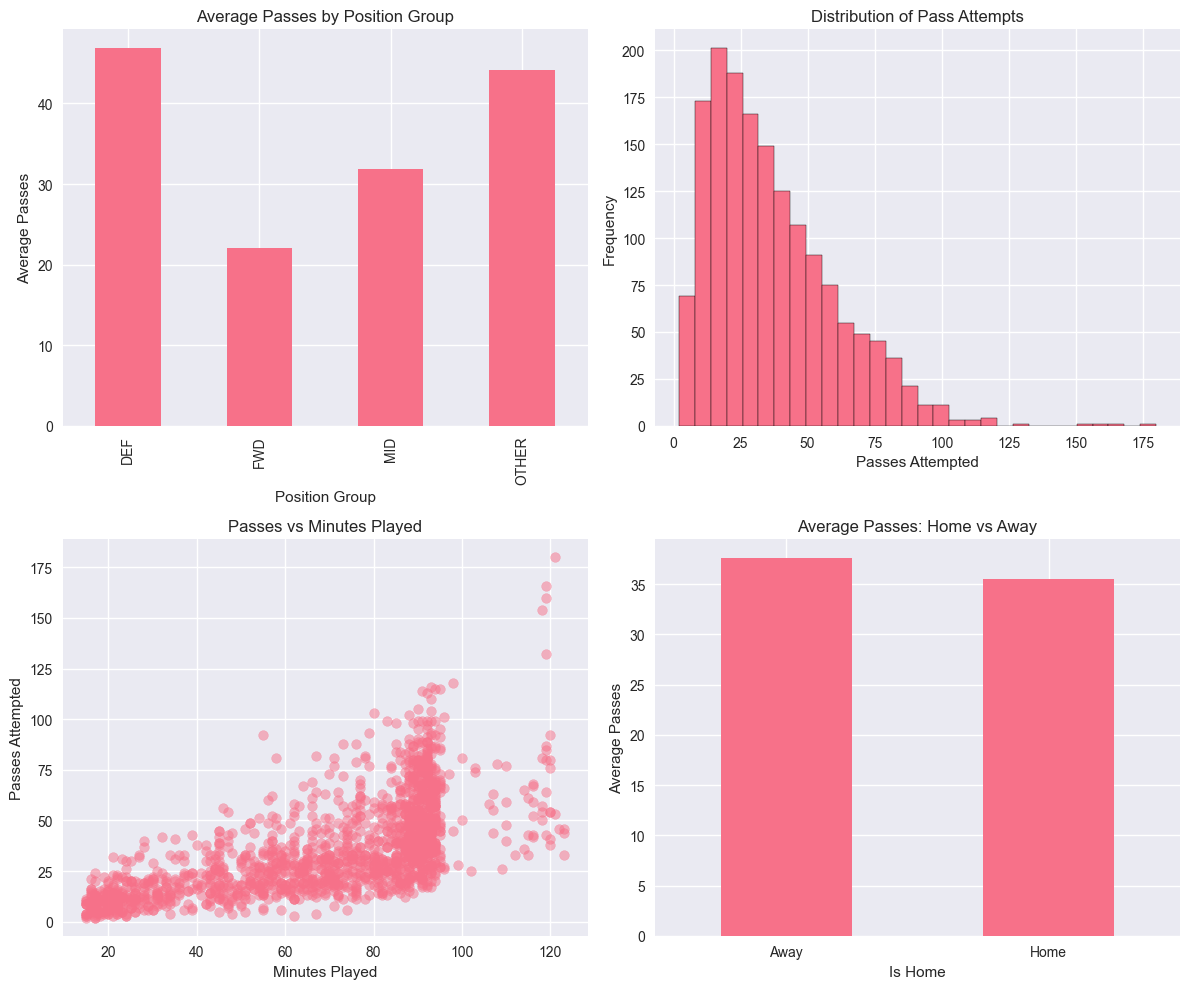

In [7]:
# Distribution of passes by position
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Passes by position group
ax = axes[0, 0]
processed_data.groupby('position_group')['passes_attempted'].mean().plot(kind='bar', ax=ax)
ax.set_title('Average Passes by Position Group')
ax.set_xlabel('Position Group')
ax.set_ylabel('Average Passes')

# Distribution of passes
ax = axes[0, 1]
ax.hist(processed_data['passes_attempted'], bins=30, edgecolor='black')
ax.set_title('Distribution of Pass Attempts')
ax.set_xlabel('Passes Attempted')
ax.set_ylabel('Frequency')

# Passes vs Minutes Played
ax = axes[1, 0]
ax.scatter(processed_data['minutes_played'], processed_data['passes_attempted'], alpha=0.5)
ax.set_title('Passes vs Minutes Played')
ax.set_xlabel('Minutes Played')
ax.set_ylabel('Passes Attempted')

# Home vs Away performance
ax = axes[1, 1]
home_away = processed_data.groupby('is_home')['passes_attempted'].mean()
home_away.plot(kind='bar', ax=ax)
ax.set_title('Average Passes: Home vs Away')
ax.set_xlabel('Is Home')
ax.set_ylabel('Average Passes')
ax.set_xticklabels(['Away', 'Home'], rotation=0)

plt.tight_layout()
plt.show()

In [8]:
# Correlation analysis
numeric_cols = processed_data.select_dtypes(include=[np.number]).columns
correlation_matrix = processed_data[numeric_cols].corr()

# Top correlations with passes_attempted
pass_correlations = correlation_matrix['passes_attempted'].sort_values(ascending=False)
print("Top correlations with passes_attempted:")
print(pass_correlations.head(10))

Top correlations with passes_attempted:
passes_attempted                1.000000
passes_completed                0.984058
minutes_percentage              0.653643
minutes_played                  0.653643
passes_completed_rolling_5      0.535809
passes_attempted_rolling_5      0.530079
form_vs_opponent                0.427939
pass_completion_rate_rolling    0.318489
last_pass_minute                0.302104
minutes_played_rolling_5        0.294031
Name: passes_attempted, dtype: float64


## 4. Model Training

In [9]:
# Prepare data for modeling
X = feature_matrix
y = processed_data['passes_attempted']
exposure = processed_data['minutes_played']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
exposure_train = exposure.iloc[X_train.index]
exposure_test = exposure.iloc[X_test.index]

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 1269 samples
Test set: 318 samples


In [10]:
# Train baseline model
baseline_model = HistoricalAverageBaseline(group_columns=['position_encoded'])
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

# Train Poisson model
poisson_model = PoissonRegression(use_exposure=True)
poisson_model.fit(X_train, y_train, exposure=exposure_train)
y_pred_poisson = poisson_model.predict(X_test, exposure=exposure_test)

print("Models trained successfully!")

Models trained successfully!


## 5. Model Evaluation

In [11]:
# Evaluate models
evaluator = PassPredictionEvaluator()

baseline_metrics = evaluator.evaluate(y_test, y_pred_baseline)
poisson_metrics = evaluator.evaluate(y_test, y_pred_poisson)

# Compare results
results_df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Poisson': poisson_metrics
}).T

print("Model Performance Comparison:")
print(results_df[['mae', 'rmse', 'r2', 'mape']].round(3))

Model Performance Comparison:
             mae    rmse     r2    mape
Baseline  16.128  21.115  0.211  82.441
Poisson   15.925  20.950  0.223  63.314


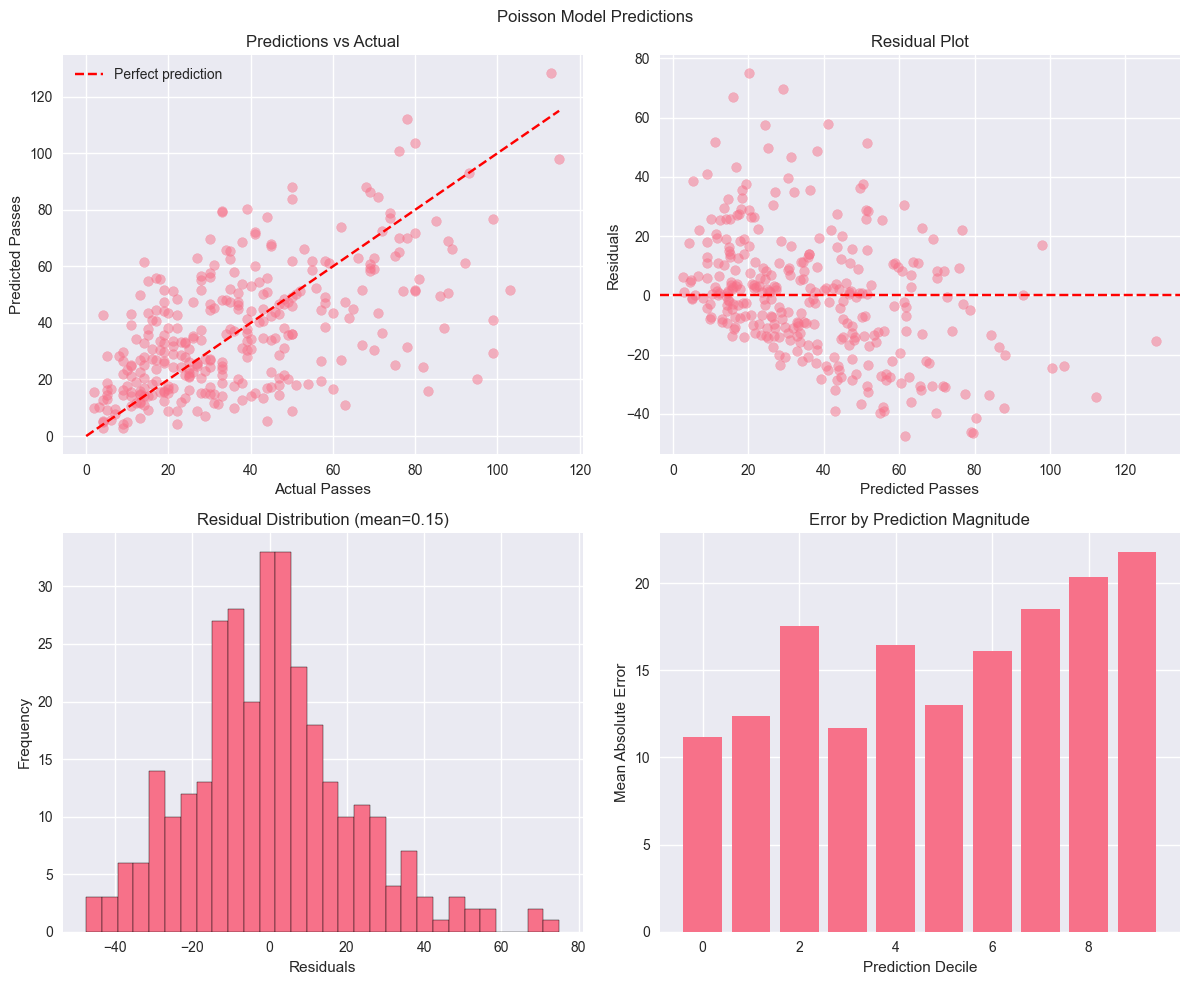

In [12]:
# Visualize predictions
fig = evaluator.plot_predictions(y_test.values, y_pred_poisson, title="Poisson Model Predictions")
plt.show()

In [13]:
# Analyze model coefficients (Poisson)
if hasattr(poisson_model, 'get_coefficients'):
    coefficients = poisson_model.get_coefficients()
    print("\nPoisson Model Coefficients:")
    print(coefficients.sort_values('P>|z|').head(10))


Poisson Model Coefficients:
                               Coef.  Std.Err.          z         P>|z|  \
const                      -1.790166  0.033002 -54.244420  0.000000e+00   
minutes_played              0.016691  0.000231  72.294035  0.000000e+00   
position_encoded            0.058978  0.004474  13.181419  1.122592e-39   
minutes_played_rolling_5   -0.004715  0.000358 -13.171671  1.277394e-39   
is_home                    -0.109357  0.009688 -11.287673  1.509809e-29   
opponent_avg_goals         -0.099596  0.012865  -7.741390  9.833581e-15   
team_avg_goals              0.091648  0.013436   6.820951  9.043973e-12   
avg_pass_length            -0.006126  0.001195  -5.125470  2.967964e-07   
passes_attempted_rolling_5  0.007129  0.001749   4.075601  4.589567e-05   
passes_completed_rolling_5  0.004845  0.001797   2.695902  7.019838e-03   

                              [0.025    0.975]  
const                      -1.854849 -1.725484  
minutes_played              0.016238  0.017143 

## 6. Performance by Position

In [14]:
# Evaluate by position group
position_groups = processed_data.iloc[X_test.index]['position_group']
position_metrics = evaluator.evaluate_by_group(
    y_test.values, 
    y_pred_poisson,
    position_groups,
    group_name='position'
)

print("Performance by Position:")
print(position_metrics[['position', 'n_samples', 'mae', 'rmse']].sort_values('mae'))

Performance by Position:
  position  n_samples        mae       rmse
1      MID         43  13.051187  17.286324
0      FWD         90  14.964999  20.867267
3      DEF         57  15.166892  19.657270
2    OTHER        128  17.902263  22.621494


<Figure size 1000x600 with 0 Axes>

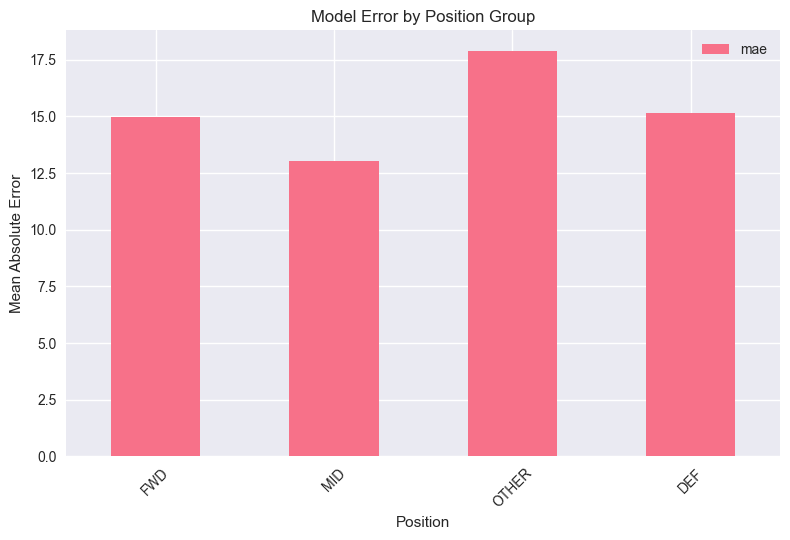

In [15]:
# Plot MAE by position
plt.figure(figsize=(10, 6))
position_metrics.plot(x='position', y='mae', kind='bar')
plt.title('Model Error by Position Group')
plt.xlabel('Position')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Top 10 Most Important Features:
                       feature  correlation
2               minutes_played     0.658163
9   passes_completed_rolling_5     0.531589
8   passes_attempted_rolling_5     0.524795
10    minutes_played_rolling_5     0.296894
11             avg_pass_length     0.179128
6               team_avg_goals     0.146044
3           team_strength_diff     0.139495
0             position_encoded     0.127842
4         team_points_per_game     0.112852
5     opponent_points_per_game    -0.088739


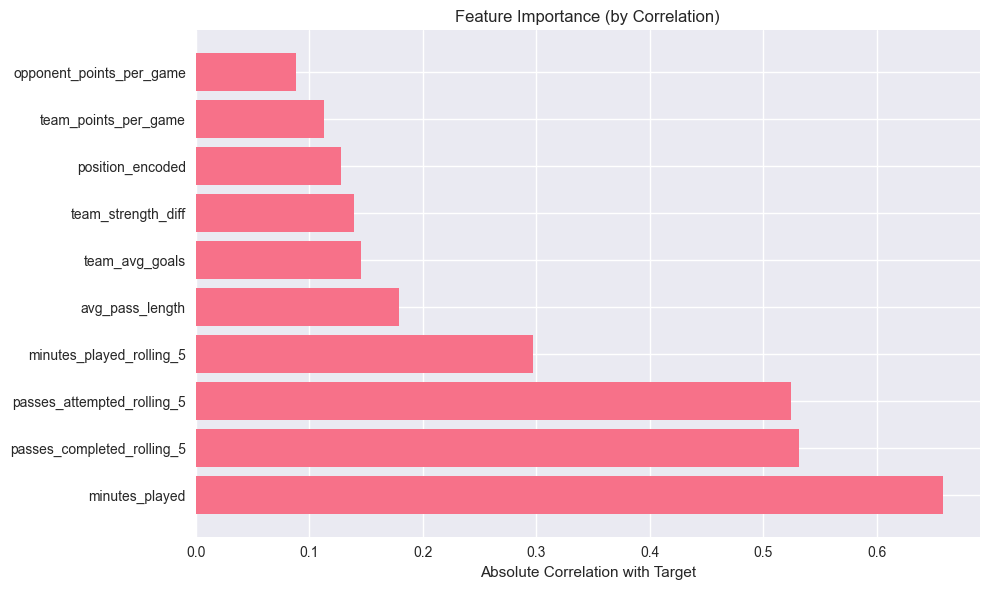

In [16]:
# Calculate feature importance using correlation with target
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'correlation': [X_train[col].corr(y_train) for col in feature_names]
}).sort_values('correlation', key=abs, ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['correlation'].abs())
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Absolute Correlation with Target')
plt.title('Feature Importance (by Correlation)')
plt.tight_layout()
plt.show()

## 8. Predictions for New Data

Example of making predictions for a hypothetical player.

In [17]:
# Create a sample player for prediction
sample_player = pd.DataFrame({
    'position_encoded': [2],  # Midfielder
    'is_home': [1],
    'minutes_played': [90],
    'team_strength_diff': [0.5],
    'team_points_per_game': [2.0],
    'opponent_points_per_game': [1.5],
    'team_avg_goals': [2.1],
    'opponent_avg_goals': [1.2],
    'passes_attempted_rolling_5': [45],
    'passes_completed_rolling_5': [38],
    'minutes_played_rolling_5': [82],
    'avg_pass_length': [15.5]
})

# Make prediction
sample_exposure = pd.Series([90])
predicted_passes = poisson_model.predict(sample_player, exposure=sample_exposure)

print(f"\nPredicted passes for sample player: {predicted_passes[0]:.1f}")

# Get prediction interval
if hasattr(poisson_model, 'predict_interval'):
    pred, lower, upper = poisson_model.predict_interval(
        sample_player, exposure=sample_exposure, alpha=0.1
    )
    print(f"90% Prediction Interval: [{lower[0]:.1f}, {upper[0]:.1f}]")


Predicted passes for sample player: 65.5
90% Prediction Interval: [52.4, 78.6]


## Next Steps

This notebook demonstrates the Phase 1 foundation of our pass prediction model. 

**Potential improvements for Phase 2+:**
1. Add tactical features (formation, playing style)
2. Implement two-stage modeling (team volume + player share)
3. Include opponent-specific conditioning
4. Add game state dynamics
5. Use more sophisticated models (XGBoost, Neural Networks)
6. Implement tactical archetype clustering

The current baseline achieves reasonable performance and provides a solid foundation for further development.